In [169]:
# Internal imports
import os
import pickle

# External imports
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
import corner
import seaborn as sns
#sns.set_theme()
import arviz as az

import emcee

# Set plot params
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

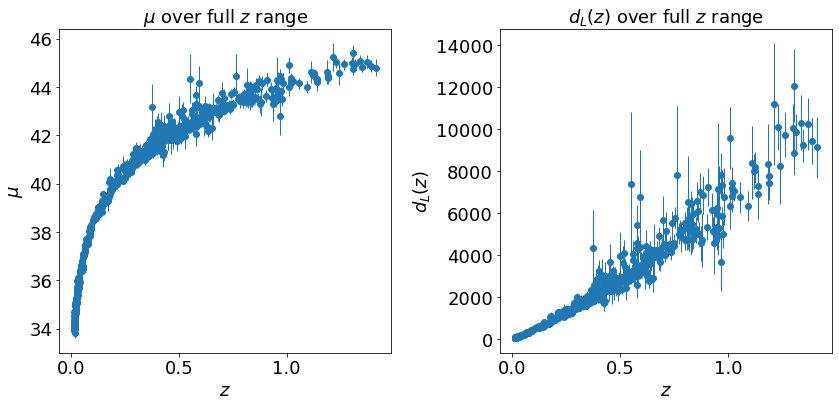

In [170]:
### Imported data
z = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 1)
mu = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 2)
delta_mu = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 3)
data4 = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 4)

### Sort data for increasing z
sortOrder = np.argsort(z)
z = z[sortOrder]
mu = mu[sortOrder]
delta_mu = delta_mu[sortOrder]
dl = 10**(mu/5-5) # Extract dl(z) from modulus
delta_dl = dl*np.log(10)*delta_mu/5

### Plot the data
fig,ax = plt.subplots(1,2, figsize = (12,6))
ax[0].scatter(z,mu)
ax[0].errorbar(z,mu,delta_mu, linewidth = 0, elinewidth = 1)
ax[0].set_title(r'$\mu$ over full $z$ range')
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$\mu$')


ax[1].scatter(z,dl)
ax[1].errorbar(z,dl,delta_dl, linewidth = 0, elinewidth = 1)

ax[1].set_title(r'$d_L(z)$ over full $z$ range')
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$d_L(z)$')

plt.tight_layout()

#### Define models

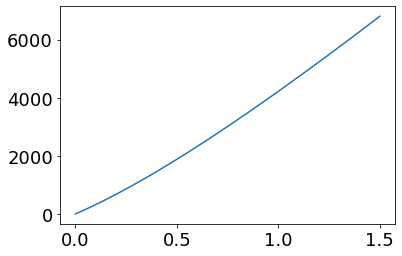

In [171]:
c = 299792458
H0 = 70000
w = 1
def lambda_CDM(z, Omega_M, Omega_Lambda):
    dl_z = np.zeros(len(z))
    for i, zi in enumerate(z):
        z_prim = np.linspace(0, zi, 100)
        Ez_prim = Omega_M * (1+z_prim)**3 + Omega_Lambda
        Hz_prim = H0 * np.sqrt(Ez_prim)
        dl_z[i] = c*(1+zi) * np.trapz(y=1/Hz_prim, x=z_prim)
    return dl_z

def omega_CDM(z, Omega_M, Omega_Lambda, omega):
    dl_z = np.zeros(len(z))
    for i, zi in enumerate(z):
        z_prim = np.linspace(0, zi, 100)
        Ez_prim = Omega_M * (1+z_prim)**3 + Omega_Lambda*(1+z_prim)**(3*(1+omega))
        Hz_prim = H0 * np.sqrt(Ez_prim)
        dl_z[i] = c*(1+zi) * np.trapz(y=1/Hz_prim, x=z_prim)
    return dl_z

z_test = np.linspace(0,1.5)
dl_test = lambda_CDM(z_test, 1,1)
plt.plot(z_test, dl_test)

#### Emcee setup

In [172]:
# Priors

# ej normalizerade

def log_prior(theta):
    Omega_M, Omega_lambda = theta
    if 0.0 < Omega_M < 1 and 0.0 < Omega_lambda < 1.0:
        return 0.0
    return -np.inf

def log_omega_prior(theta):
    Omega_M, Omega_lambda, omega = theta
    if 0.0 < Omega_M < 1 and 0.0 < Omega_lambda < 1.0 and -np.inf < omega < np.inf:
        return 0.0
    return -np.inf

def log_lambda_likelihood(theta, z, dl, dl_err):
    # Use data weights equal to the measurement variance - i.e. set scale to 1 (known)
    W = np.diag(dl_err**(-2))
    Omega_M, Omega_lambda = theta
    dl_z = lambda_CDM(z, Omega_M, Omega_lambda)
    if np.any(np.isnan(dl_z)):
        return -np.inf
    
    normalization = - 0.5*(np.log(2*np.pi)*len(z) + np.sum(2*np.log(dl_err)) )
    return -0.5*(dl-dl_z)@W@(dl-dl_z) + normalization

def log_omega_likelihood(theta, z, dl, dl_err):
    # Use data weights equal to the measurement variance - i.e. set scale to 1 (known)
    W = np.diag(dl_err**(-2))
    Omega_M, Omega_lambda, w = theta
    dl_z = omega_CDM(z, Omega_M, Omega_lambda, w) 
    if np.any(np.isnan(dl_z)):
        return -np.inf
    normalization = - 0.5*(np.log(2*np.pi)*len(z) + np.sum(2*np.log(dl_err)) )
    return -0.5*(dl-dl_z)@W@(dl-dl_z) + normalization

def log_lambda_posterior(theta, z, dl, dl_err):
    return log_lambda_likelihood(theta, z, dl, dl_err) + log_prior(theta)

def log_omega_posterior(theta, z, dl, dl_err):
    return log_omega_likelihood(theta, z, dl, dl_err) + log_omega_prior(theta)

log_lambda_likelihood((0.3, 0.7), z, dl, delta_dl)
log_omega_likelihood((0.3, 0.7, -1.11581788), z, dl, delta_dl)

-3445.890045559967

In [173]:
nll_lambda = lambda *args: -log_lambda_likelihood(*args)
nll_omega = lambda *args: -log_omega_likelihood(*args)

theta_hat_lambda = sc.optimize.minimize(nll_lambda, [0.5,0.5], args=(z, dl, delta_dl), bounds = ((1e-5,10),(1e-5,10)))
theta_hat_omega = sc.optimize.minimize(nll_omega, [0.5,0.5, -1], args=(z, dl, delta_dl), bounds = ((1e-5,10),(1e-5,10),(-np.inf, np.inf)))
max_likelihood_lambda = -theta_hat_lambda.fun
max_likelihood_omega = -theta_hat_omega.fun

print(max_likelihood_lambda)
print(max_likelihood_omega)
print(theta_hat_lambda.x)
print(theta_hat_omega.x)

-3434.463121783899
-3434.3328256493187
[0.30012496 0.71083722]
[ 0.33894299  0.67707101 -1.11581788]


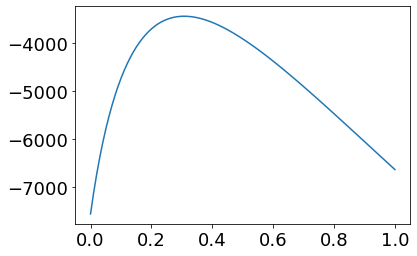

In [174]:
Omega = np.linspace(0,1,100)
theta = np.zeros(len(Omega))
for i, w in enumerate(Omega):
    theta[i] = log_lambda_likelihood((w,0.7), z, dl,delta_dl)
plt.plot(Omega,theta)

In [175]:
def bic(log_L_max, len_data, len_params):
    return 2*log_L_max - len_params*np.log(len_data)

def aic(log_L_max, len_params):
    return 2*log_L_max - 2*len_params
# Lambda model
lambda_bic = bic(max_likelihood_lambda, len(z), 2)
lambda_aic = aic(max_likelihood_lambda, 2)

print(f'Lambda model\n\tBIC={lambda_bic:.2f} \t AIC={lambda_aic:.2f}')

# Omega model
omega_bic = bic(max_likelihood_omega, len(z), 2)
omega_aic = aic(max_likelihood_omega, 2)
print(f'Omega model\n\tBIC={omega_bic:.2f} \t AIC={omega_aic:.2f}')

Lambda model
	BIC=-6881.65 	 AIC=-6872.93
Omega model
	BIC=-6881.39 	 AIC=-6872.67


#### Calculate central values
Do this by emcee sampling posterior.

In [176]:
n_walkers = 6
burn_in = 100
n_samples = 500

In [178]:
# Lambda model
n_dim = 2
initial = np.random.rand(n_walkers, n_dim)
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_lambda_posterior, args=(z, dl, delta_dl))


if(os.path.isfile('trace_lambda_task2.p')):
    print('Using pickled trace')
    trace_lambda = pickle.load( open( 'trace_lambda_task2.p', 'rb' ) )
else:
    print('No trace file found. Running MCMC for lambda model')
    # Run burn in
    sampler.run_mcmc(initial, burn_in)
    final_state = sampler.get_last_sample()
    # Sample posterior
    sampler.reset()
    sampler.run_mcmc(final_state, n_samples)
    trace_lambda = sampler.get_chain()
    pickle.dump(trace_lambda, open( "trace_lambda_task2.p", "wb" ))

No trace file found. Running MCMC for lambda model


In [179]:
# Omega model
n_dim = 3
initial = np.random.rand(n_walkers, n_dim)
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_omega_posterior, args=(z, dl, delta_dl))

if(os.path.isfile('trace_omega_task2.p')):
    print('Using pickled trace')
    trace_omega = pickle.load( open( 'trace_omega_task2.p', 'rb' ) )
else:
    print('No trace file found. Running MCMC for omega model')
    # Run burn in
    sampler.run_mcmc(initial, burn_in)
    final_state = sampler.get_last_sample()
    # Sample posterior
    sampler.reset()
    res = sampler.run_mcmc(final_state, n_samples)
    trace_omega = sampler.get_chain()
    pickle.dump(trace_omega, open( "trace_omega_task2.p", "wb" ))

No trace file found. Running MCMC for omega model


/home/ericl/miniconda3/envs/physics/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
print(sampler.acceptance_fraction)


fig, axs = plt.subplots(1,2, figsize=(12,6))
for i in range(trace.shape[2]):
    for j in range(trace.shape[1]):
        axs[i].plot(trace[:, j,i])
axs[0].set_xlabel('Samples')
axs[1].set_xlabel('Samples')

axs[0].set_ylabel(r'$\Omega_M$')
axs[1].set_ylabel(r'$\Omega_{\Lambda}$')
plt.tight_layout()

#### Calculate central values: mean, mode, median

In [120]:
# lambda model
# Use Scipy to maximize the posterior to get the mode
lambda_trace = np.concatenate(trace, axis=0)
nll_lambda = lambda *args: -log_lambda_posterior(*args)
theta_hat_lamda = sc.optimize.minimize(nll_lambda, [0.5,0.5], args=(z, dl, delta_dl), bounds = ((1e-5,10),(1e-5,10)))

lambda_omega_m_mean = np.mean(lambda_trace[:,0])
lambda_omega_l_mean = np.mean(lambda_trace[:,1])

lambda_omega_m_mode = theta_hat_lambda.x[0]
lambda_omega_l_mode = theta_hat_lambda.x[1]

lambda_omega_m_median = np.median(lambda_trace[:,0])
lambda_omega_l_median = np.median(lambda_trace[:,1])

print(f'Lambda model\n\t Mean: Omega_M = {lambda_omega_m_mean:.6f} \t Omega_l = {lambda_omega_l_mean:.6f}\
\n\t Mode: Omega_M = {lambda_omega_m_mode:.6f} \t Omega_l = {lambda_omega_l_mode:.6f}\
\n\t Median: Omega_M = {lambda_omega_m_median:.6f} \t Omega_l = {lambda_omega_l_median:.6f}')

(500, 4, 2)
(2000, 2)
Lambda model
	 Mean: Omega_M = 0.298661 	 Omega_l = 0.712746
	 Mode: Omega_M = 0.300125 	 Omega_l = 0.710837
	 Median: Omega_M = 0.298194 	 Omega_l = 0.711852


#### Extract the posterior for $\Omega_M$

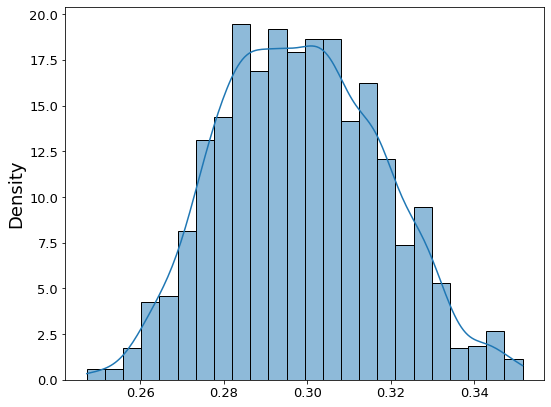

In [142]:
omega_m_post = lambda_trace[:,0]
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=omega_m_post, kde=True, stat='density', ax=ax)

plt.tight_layout()
plt.savefig('figures_task2/omega_m_posterior.png')

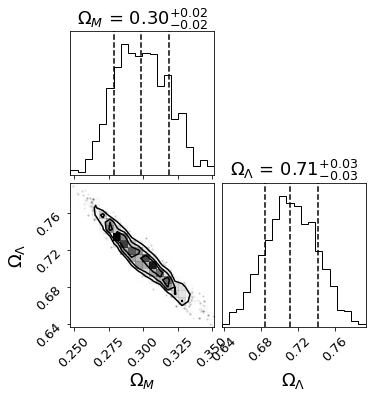

In [139]:
# Set plot params
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

fig_corner = corner.corner(lambda_trace,labels =[r'$\Omega_M$', '$\Omega_\Lambda$'], show_titles=True, quantiles=[0.16, 0.5, 0.84]);
plt.savefig('figures_task2/corner.png')